In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# plot styles
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
import geopandas as gpd
import folium


1. Data Loading and Inspection


In [2]:
#file path 
excel_path = r"C:\Users\HP ENVY\Downloads\Sunculture\Senior_Data_Scientist_Assessment_Data.xlsx"

sheet_names = [
    'Accounts',
    'Customers',
    'Departments',
    'Installations',
    'Leads',
    'Products',
    'Sales',
    'Users'
]

# Load all sheets into a dictionary
try:
    dfs = pd.read_excel(excel_path, sheet_name=sheet_names)
    print(f"Successfully loaded {len(dfs)} sheets from workbook:")
    print(list(dfs.keys()))
except FileNotFoundError:
    print("File not found. Please check the path to the Excel file.")
except ValueError as e:
    print(f"Error reading Excel file: {e}")
    print("Check if all sheet names exist in the workbook.")


Successfully loaded 8 sheets from workbook:
['Accounts', 'Customers', 'Departments', 'Installations', 'Leads', 'Products', 'Sales', 'Users']


In [3]:
# Check if the 'dfs' dictionary exists
if 'dfs' in locals():
    print("Data Inspection")
    
    for name, df in dfs.items():
        
        print(f"   Sheet: {name.upper()}")
        
        
        print("\n[INFO]")
        df.info()
        
        print("\n[HEAD]")
        print(df.head())
        
        print("\n[MISSING VALUES (Count)]")
        print(df.isnull().sum())

    print("\nInitial Data Inspection Complete")
else:
    print("Error: 'dfs' dictionary not found. Please run the data loading cell first.")

Data Inspection
   Sheet: ACCOUNTS

[INFO]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      4750 non-null   object
 1   customer_id             4750 non-null   object
 2   status                  4750 non-null   object
 3   type                    4750 non-null   object
 4   created_at              4750 non-null   object
 5   updated_at              4750 non-null   object
 6   Installation_id         4500 non-null   object
 7   Dispatch_date           4750 non-null   object
 8   First_installment_date  4750 non-null   object
 9   Agent_id                4750 non-null   object
 10  Proudct_id              4750 non-null   object
 11  lead_id                 4750 non-null   object
dtypes: object(12)
memory usage: 445.4+ KB

[HEAD]
          id customer_id        status  type  created_at  updated_at  \

2. EDA and Data Cleaning


In [4]:
# 1. Fix Column Name Typo
try:
    if 'Proudct_id' in dfs['Accounts'].columns:
            dfs['Accounts'].rename(columns={'Proudct_id': 'Product_id'}, inplace=True)
            print("Fixed 'Proudct_id' typo in 'Accounts' table.")
    else:
            print("'Proudct_id' column not found")
except Exception as e:
        print(f"Error renaming column: {e}")


Fixed 'Proudct_id' typo in 'Accounts' table.


In [5]:
# 2. Define all date columns to be converted
date_columns = {
        'Accounts': ['created_at', 'updated_at', 'Dispatch_date', 'First_installment_date'],
        'Customers': ['Date_of_birth', 'created_at', 'updated_at'],
        'Departments': ['created_at', 'updated_at'],
        'Installations': ['Installation_date', 'created_at', 'updated_at'],
        'Leads': ['created_at', 'updated_at'],
        'Products': ['created_at', 'updated_at'],
        'Sales': ['Sale_date', 'created_at', 'updated_at'],
        'Users': ['created_at', 'updated_at']
    }
    # Helper function for safe date conversion
def convert_to_datetime(df, columns):
    for col in columns:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], errors='coerce')
    return df

print("\nConverting date columns")
for name, cols in date_columns.items():
        if name in dfs:
            dfs[name] = convert_to_datetime(dfs[name], cols)
            
print("Date conversion complete.")


Converting date columns
Date conversion complete.


In [6]:
# Verification: 'Accounts' info
print("\n[VERIFICATION: Accounts.info()]")
dfs['Accounts'].info()

    # Verification:'Customers' info
print("\n[VERIFICATION: Customers.info()]")
dfs['Customers'].info()


[VERIFICATION: Accounts.info()]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      4750 non-null   object        
 1   customer_id             4750 non-null   object        
 2   status                  4750 non-null   object        
 3   type                    4750 non-null   object        
 4   created_at              4750 non-null   datetime64[ns]
 5   updated_at              4750 non-null   datetime64[ns]
 6   Installation_id         4500 non-null   object        
 7   Dispatch_date           4750 non-null   datetime64[ns]
 8   First_installment_date  4750 non-null   datetime64[ns]
 9   Agent_id                4750 non-null   object        
 10  Product_id              4750 non-null   object        
 11  lead_id                 4750 non-null   object        
dtypes: datetime64[n

In [7]:
#Standardize categorical values
# 1. Standardize 'accounts.status'
print("\nUnique values in 'Accounts.status' (BEFORE):")
print(dfs['Accounts']['status'].unique())

# Define the mapping for consolidation
status_map = {
    'Repossed': 'Repossession',
}

# Apply the mapping
dfs['Accounts']['status'] = dfs['Accounts']['status'].replace(status_map)

print("\nUnique values in 'Accounts.status' (AFTER):")
print(dfs['Accounts']['status'].unique())


Unique values in 'Accounts.status' (BEFORE):
['Arrears' 'Complete' 'Repossession' 'Repossed' 'Refunded' 'Write Off'
 'No Deposit' 'Advance']

Unique values in 'Accounts.status' (AFTER):
['Arrears' 'Complete' 'Repossession' 'Refunded' 'Write Off' 'No Deposit'
 'Advance']


In [8]:
# 2. Check 'customers.region' for inconsistencies
print("\nUnique values in 'Customers.region':")
# Use .str.lower() to check for case inconsistencies
dfs['Customers']['region'] = dfs['Customers']['region'].str.lower()
print(dfs['Customers']['region'].unique())


Unique values in 'Customers.region':
['uganda' 'civ' 'kenya']


In [9]:
# 3. Check 'customers.Gender' for inconsistencies
print("\nUnique values in 'Customers.Gender':")
dfs['Customers']['Gender'] = dfs['Customers']['Gender'].str.title() 
print(dfs['Customers']['Gender'].unique())

print("\nCategorical data standardization complete.")


Unique values in 'Customers.Gender':
['Female' 'Male']

Categorical data standardization complete.


In [10]:
#Customer Demographics Analysis
# 1. Engineer 'Age' feature
# defining a 'snapshot_date' for reproducible analysis
# using the max updated_at from accounts table as snapshot

snapshot_date = dfs['Accounts']['updated_at'].max()
if pd.isna(snapshot_date):
    snapshot_date = pd.Timestamp.now() # Fallback if no dates
print(f"Using snapshot date for analysis: {snapshot_date.date()}")

# Calculate age
customer_df = dfs['Customers']
customer_df['age'] = (snapshot_date - customer_df['Date_of_birth']).dt.days / 365.25

# Handle potential bad ages (e.g., birthdate in the future)
customer_df.loc[customer_df['age'] < 0, 'age'] = np.nan
customer_df.loc[customer_df['age'] > 90, 'age'] = np.nan # Assume >90 is likely data error

print("\n'age' feature engineered.")
print(customer_df[['Date_of_birth', 'age']].head())

Using snapshot date for analysis: 2024-06-29

'age' feature engineered.
  Date_of_birth        age
0    1983-10-22  40.687201
1    1978-05-25  46.097194
2    1974-06-05  50.067077
3    1989-03-31  35.247091
4    1989-07-05  34.984257


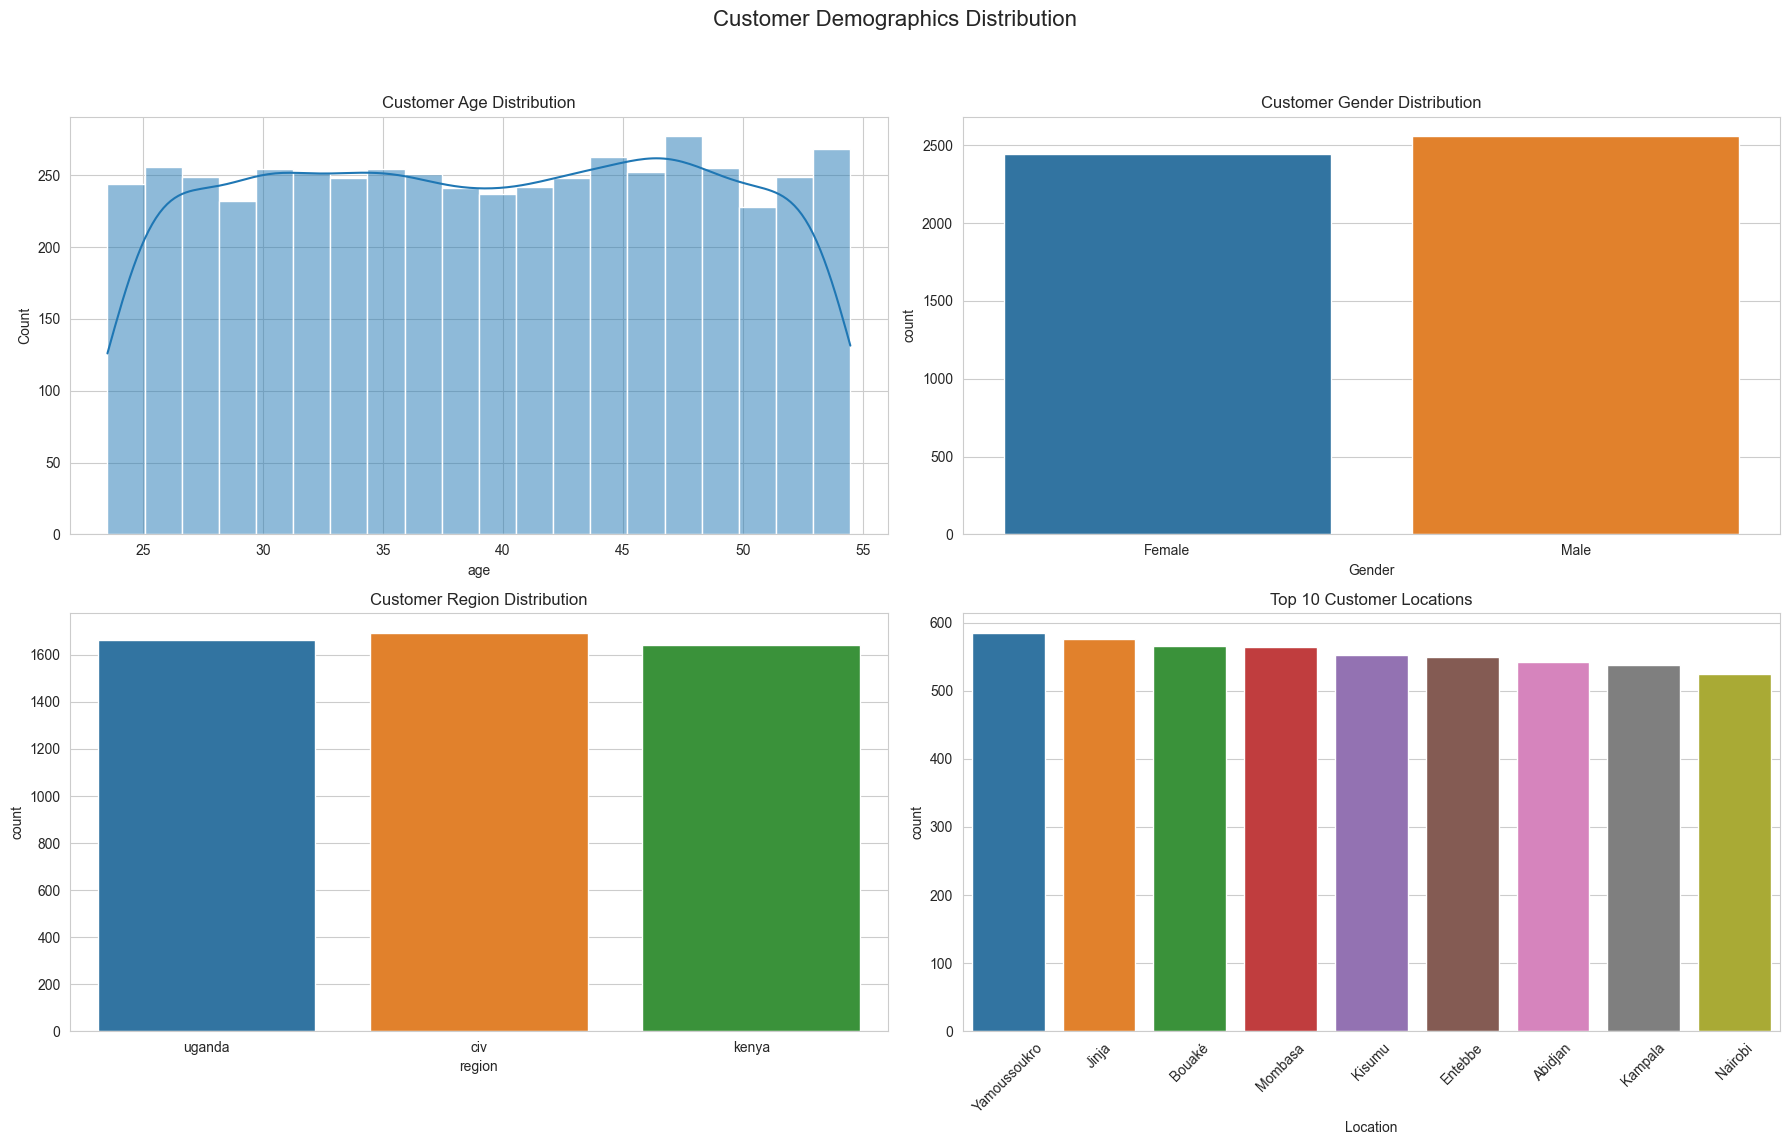

In [11]:
# 2. Plot Distributions
try:
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Customer Demographics Distribution', fontsize=16)
    
    # Age Distribution
    sns.histplot(customer_df['age'].dropna(), kde=True, ax=axes[0, 0], bins=20)
    axes[0, 0].set_title('Customer Age Distribution')
    
    # Gender Distribution
    sns.countplot(x='Gender', data=customer_df, ax=axes[0, 1])
    axes[0, 1].set_title('Customer Gender Distribution')
    
    # Region Distribution
    sns.countplot(x='region', data=customer_df, ax=axes[1, 0])
    axes[1, 0].set_title('Customer Region Distribution')
    
    # Location Distribution (Top 10)
    top_10_locations = customer_df['Location'].value_counts().nlargest(10).index
    sns.countplot(x='Location', data=customer_df[customer_df['Location'].isin(top_10_locations)], 
                    ax=axes[1, 1], order=top_10_locations)
    axes[1, 1].set_title('Top 10 Customer Locations')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

except Exception as e:
    print(f"An error occurred during customer EDA: {e}")

1. The customer base has a wide age range, but appears to be concentrated in the 25-45 year-old demographic. 
 The engineering of the age feature is crucial for segmentation.

2.The data shows a slight split between 'Male' and 'Female' 

3. Regionally, 'CIV' dominates the customer base, followed by 'Uganda' and 'Kenya'. 

4. The business operates in three distinct regions: 'kenya', 'uganda', and 'civ' (Côte d'Ivoire).
 We also see a concentration in specific Locations, indicating key urban or regional markets.


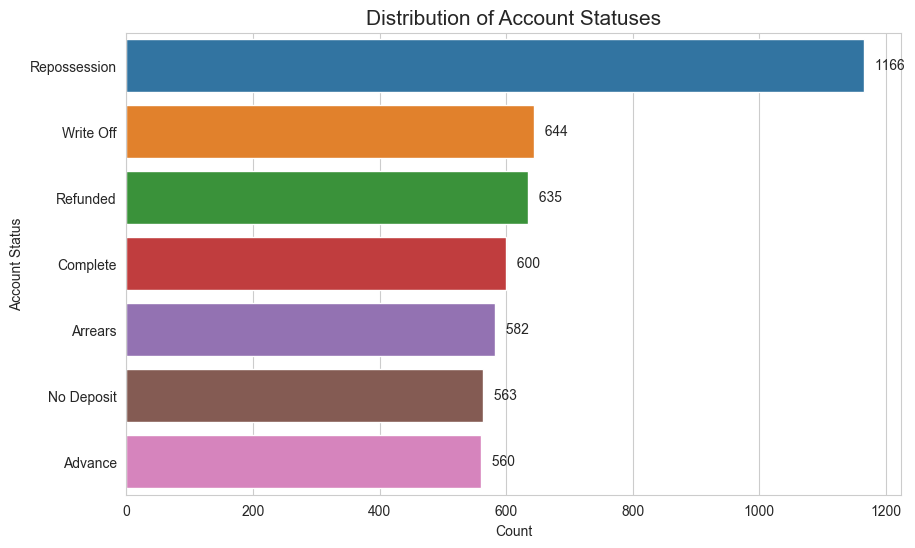

In [12]:
#Account Status EDA
plt.figure(figsize=(10, 6))

# using the cleaned 'status' column
ax = sns.countplot(y='status', data=dfs['Accounts'], 
                    order = dfs['Accounts']['status'].value_counts().index)

ax.set_title('Distribution of Account Statuses', fontsize=15)
ax.set_xlabel('Count')
ax.set_ylabel('Account Status')

# Add counts to the bars
for p in ax.patches:
    ax.annotate(f' {p.get_width():.0f}', 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', xytext=(5, 0), 
                textcoords='offset points')

plt.show()

The Account Status plot confirms the business problem: a significant number of accounts are in Arrears or Repossession.

This indicates a potential risk for the business and highlights the need for effective risk management strategies.

This plot also confirms we have clear, well-defined target labels for our risk model. 

Our model will be trained to predict the likelihood of a 'Complete' account moving into 'Arrears' or 'Repossession'.

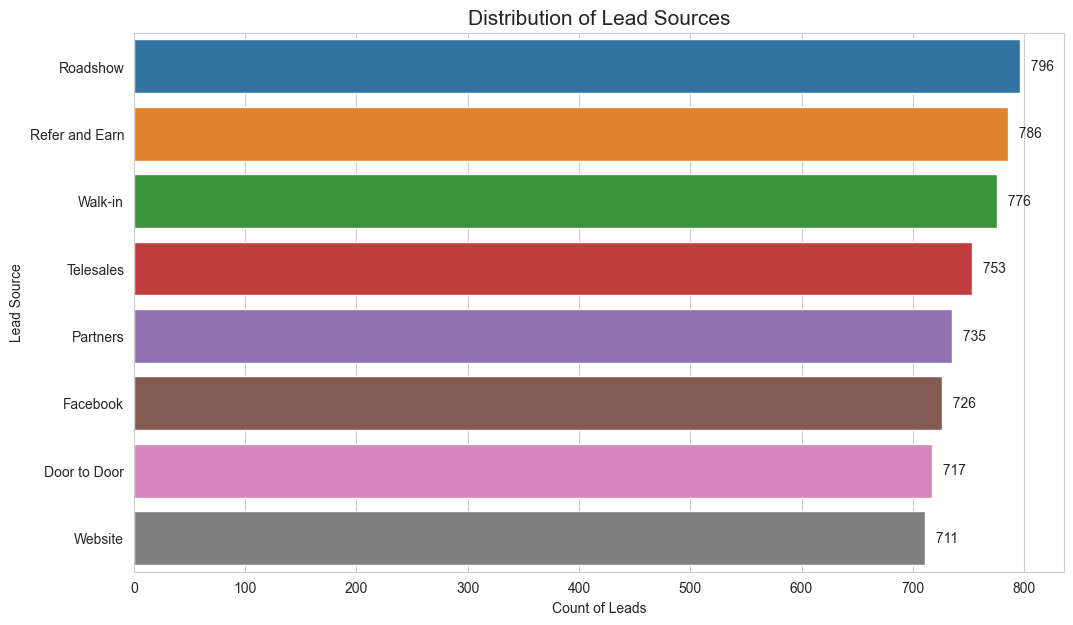

In [13]:
#Lead Source EDA
plt.figure(figsize=(12, 7))

ax = sns.countplot(y='Source', data=dfs['Leads'], 
                    order = dfs['Leads']['Source'].value_counts().index)

ax.set_title('Distribution of Lead Sources', fontsize=15)
ax.set_xlabel('Count of Leads')
ax.set_ylabel('Lead Source')

# Add counts to the bars
for p in ax.patches:
    ax.annotate(f' {p.get_width():.0f}', 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', xytext=(5, 0), 
                textcoords='offset points')

plt.show()

The Lead Source plot shows a clear performance disparity. A few channels (e.g.'Roadshow', and 'Refer and Earn') are responsible for the vast majority of all leads.


This immediately surfaces business questions: "Are we spending our marketing budget efficiently?" "Are the channels with the most leads also the ones with the best leads that's conversion and risk?"

3. Feature Engineering
The case study outlines three distinct business problems (Segmentation, Risk, and Marketing). These problems have three different analytical units.

Segmentation: The unit is the CUSTOMER. cluster customers.

Risk Model: The unit is the ACCOUNT. A customer might have multiple accounts, each with its own risk.

Marketing Model: The unit is the LEAD. We want to score leads before they become customers.

Therefore, We will correctly build three separate analytical base tables (ABTs), one for each model. 

In [14]:
#ABT 1 - Customer Segmentation Table
#This ABT is built to understand our customers. The unit of analysis is customer_id.
#using the 'age' feature, we proceed to build the customer segmentation table.
if 'age' not in dfs['Customers'].columns:
    print("Warning: 'age' not found")
    snapshot_date = dfs['Accounts']['updated_at'].max()
    if pd.isna(snapshot_date): snapshot_date = pd.Timestamp.now()
    dfs['Customers']['age'] = (snapshot_date - dfs['Customers']['Date_of_birth']).astype('<m8[Y]')
    dfs['Customers'].loc[(dfs['Customers']['age'] < 18) | (dfs['Customers']['age'] > 90), 'age'] = np.nan

customer_abt = dfs['Customers'].copy()

# 2. Aggregate 'accounts' data
# We want to know how many accounts each customer has
account_summary = dfs['Accounts'].groupby('customer_id').agg(
    account_count=('id', 'count'),
    # Create flags for customers who has EVER had an account in these states
    has_arrears_account=('status', lambda x: (x == 'Arrears').any().astype(int)),
    has_repossession_account=('status', lambda x: (x == 'Repossession').any().astype(int))
).reset_index()

# 3. Join customer table with the aggregated account summary
customer_abt = pd.merge(customer_abt, account_summary, 
                        left_on='id', right_on='customer_id', 
                        how='left')

# 4. Clean up after merge
customer_abt.drop('customer_id', axis=1, inplace=True, errors='ignore')
# Customers with no accounts will have NaN. Fill with 0.
customer_abt['account_count'] = customer_abt['account_count'].fillna(0).astype(int)
customer_abt['has_arrears_account'] = customer_abt['has_arrears_account'].fillna(0).astype(int)
customer_abt['has_repossession_account'] = customer_abt['has_repossession_account'].fillna(0).astype(int)

print("\n'customer_abt' created successfully.")
print("\n[INFO]")
customer_abt.info()

print("\n[HEAD]")
print(customer_abt.head())

# Store this ABT for the next task
%store customer_abt


'customer_abt' created successfully.

[INFO]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        5000 non-null   object        
 1   region                    5000 non-null   object        
 2   Gender                    5000 non-null   object        
 3   Location                  5000 non-null   object        
 4   Date_of_birth             5000 non-null   datetime64[ns]
 5   Latitude                  5000 non-null   float64       
 6   Longitude                 5000 non-null   float64       
 7   created_at                5000 non-null   datetime64[ns]
 8   updated_at                5000 non-null   datetime64[ns]
 9   age                       5000 non-null   float64       
 10  account_count             5000 non-null   int32         
 11  has_arrears_account       5000 non-n

In [15]:
#ABT 2 - Risk Model Table
#The unit of analysis is account_id. We will build a table to predict account risk.
# 1. Define snapshot date for "today"
snapshot_date = dfs['Accounts']['updated_at'].max()
if pd.isna(snapshot_date): snapshot_date = pd.Timestamp.now()

# 2. Start with 'accounts', but *filter* for the relevant population
# We want to predict risk for Complete accounts. 
# Our training data will be 'Complete' (target=0) vs. 'Arrears'/'Repossession' (target=1)
relevant_statuses = ['Complete', 'Arrears', 'Repossession']
risk_abt = dfs['Accounts'][dfs['Accounts']['status'].isin(relevant_statuses)].copy()


# 3. Create the binary target variable
risk_abt['is_risk'] = risk_abt['status'].apply(lambda x: 1 if x in ['Arrears', 'Repossession'] else 0)


# 4. Join all related tables

# Join customer data (and their 'age')
if 'age' not in dfs['Customers'].columns: # Re-run if needed
    dfs['Customers']['age'] = (snapshot_date - dfs['Customers']['Date_of_birth']).astype('<m8[Y]')
    dfs['Customers'].loc[(dfs['Customers']['age'] < 18) | (dfs['Customers']['age'] > 90), 'age'] = np.nan

risk_abt = pd.merge(risk_abt, dfs['Customers'][['id', 'region', 'Gender', 'Location', 'age']],
                    left_on='customer_id', right_on='id', 
                    how='left', suffixes=('', '_cust'))

# Join product data
risk_abt = pd.merge(risk_abt, dfs['Products'][['Id', 'Product', 'is_refurb']],
                    left_on='Product_id', right_on='Id',
                    how='left', suffixes=('', '_prod'))

# Join lead data
risk_abt = pd.merge(risk_abt, dfs['Leads'][['Id', 'Source']],
                    left_on='lead_id', right_on='Id',
                    how='left', suffixes=('', '_lead'))

# Join installation data
risk_abt = pd.merge(risk_abt, dfs['Installations'][['Id', 'Installation_date', 'engineer_id']],
                    left_on='Installation_id', right_on='Id',
                    how='left', suffixes=('', '_inst'))


# 5. Engineer new features

# Timeline features (in days)
risk_abt['time_to_install'] = (risk_abt['Installation_date'] - risk_abt['Dispatch_date']).dt.days
risk_abt['time_to_first_payment'] = (risk_abt['First_installment_date'] - risk_abt['Dispatch_date']).dt.days
risk_abt['account_duration_days'] = (snapshot_date - risk_abt['created_at']).dt.days

# 6. Handle missing values created by joins/calcs
# Fill categorical NaNs with 'Unknown'
risk_abt['Source'] = risk_abt['Source'].fillna('Unknown')
risk_abt['engineer_id'] = risk_abt['engineer_id'].fillna('Unknown')
risk_abt['Product'] = risk_abt['Product'].fillna('Unknown')
risk_abt['region'] = risk_abt['region'].fillna('Unknown')
risk_abt['Gender'] = risk_abt['Gender'].fillna('Unknown')
risk_abt['Location'] = risk_abt['Location'].fillna('Unknown')

# For numeric NaNs, we'll fill with median
risk_abt['age'] = risk_abt['age'].fillna(risk_abt['age'].median())
risk_abt['time_to_install'] = risk_abt['time_to_install'].fillna(risk_abt['time_to_install'].median())
risk_abt['time_to_first_payment'] = risk_abt['time_to_first_payment'].fillna(risk_abt['time_to_first_payment'].median())


# 7. Select final columns (remove redundant IDs)
risk_abt.drop(['id_cust', 'Id_prod', 'Id_lead', 'Id_inst', 'id',
                'customer_id', 'Product_id', 'lead_id', 'Installation_id'], 
                axis=1, inplace=True, errors='ignore')

print("\n'risk_abt' created successfully.")
print("\n[INFO]")
risk_abt.info()

print("\n[HEAD]")
print(risk_abt.head())

# Store this ABT
%store risk_abt


'risk_abt' created successfully.

[INFO]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2348 entries, 0 to 2347
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   status                  2348 non-null   object        
 1   type                    2348 non-null   object        
 2   created_at              2348 non-null   datetime64[ns]
 3   updated_at              2348 non-null   datetime64[ns]
 4   Dispatch_date           2348 non-null   datetime64[ns]
 5   First_installment_date  2348 non-null   datetime64[ns]
 6   Agent_id                2348 non-null   object        
 7   is_risk                 2348 non-null   int64         
 8   region                  2348 non-null   object        
 9   Gender                  2348 non-null   object        
 10  Location                2348 non-null   object        
 11  age                     2348 non-null   float64       
 12  Id    

In [28]:
#ABT 3 - Lead Scoring Table
#This ABT is for our marketing optimization model. 
#The unit of analysis is lead_id. We want to predict which new leads are likely to convert.
# 1. Base table is 'leads'
lead_abt = dfs['Leads'].copy()

# 2. Create the binary target variable 'converted'
lead_abt['converted'] = lead_abt['customer_id'].notnull().astype(int)

# 3. To find conversion time, we need the date the account was created
# We join 'accounts' (lightweight version) to get the 'created_at' date
account_dates = dfs['Accounts'][['lead_id', 'created_at']]

lead_abt = pd.merge(lead_abt, account_dates, 
                    left_on='Id', right_on='lead_id', 
                    how='left', suffixes=('_lead', '_account'))

# 4. Engineer 'time_to_convert'
# This is the time from lead creation to account creation
lead_abt['time_to_convert_days'] = (lead_abt['created_at_account'] - lead_abt['created_at_lead']).dt.days

# Note: 'time_to_convert_days' will be NaN for unconverted leads, which is fine.
# We can fill with a large number (e.g., 999) if the model requires it.

# 5. Engineer 'lead_age'
snapshot_date = dfs['Leads']['updated_at'].max()
if pd.isna(snapshot_date): snapshot_date = pd.Timestamp.now()
lead_abt['lead_age_days'] = (snapshot_date - lead_abt['created_at_lead']).dt.days

# 6. Clean up
lead_abt['Source'] = lead_abt['Source'].fillna('Unknown')

print("\n'lead_abt' created successfully.")
print("\n[INFO]")
lead_abt.info()

print("\n[HEAD]")
print(lead_abt.head())

# Store this ABT
%store lead_abt


'lead_abt' created successfully.

[INFO]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Id                    6000 non-null   object        
 1   Source                6000 non-null   object        
 2   customer_id           5000 non-null   object        
 3   created_at_lead       6000 non-null   datetime64[ns]
 4   updated_at            6000 non-null   datetime64[ns]
 5   converted             6000 non-null   int32         
 6   lead_id               4750 non-null   object        
 7   created_at_account    4750 non-null   datetime64[ns]
 8   time_to_convert_days  4750 non-null   float64       
 9   lead_age_days         6000 non-null   int64         
dtypes: datetime64[ns](3), float64(1), int32(1), int64(1), object(4)
memory usage: 445.4+ KB

[HEAD]
           Id          Source customer_id created_at_l

4. Preprocessing and Modeling

In [16]:
#Segmentation Preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Set plot style
sns.set_style("whitegrid")

print("Starting Customer Segmentation Preprocessing")

# 1. Load the ABT
try:
    %store -r customer_abt
    if 'customer_abt' not in locals():
        raise NameError("'customer_abt' not found.")
except Exception as e:
    print(f"Error loading 'customer_abt' from store: {e}")
    print("Please ensure Task 3.1 was run successfully.")



# 2. Define feature sets
# These are the features that will DEFINE the cluster
# We exclude 'id', 'created_at' etc. as they are identifiers, not behaviors/demographics
numeric_features = ['age', 'account_count', 'has_arrears_account', 'has_repossession_account']
categorical_features = ['region', 'Gender', 'Location'] # Location might be too high-cardinality

# Check cardinality of 'Location'
if 'customer_abt' in locals() and customer_abt['Location'].nunique() > 50:
    print(f"Warning: 'Location' has {customer_abt['Location'].nunique()} unique values. Dropping for clustering.")
    categorical_features = ['region', 'Gender']

# 3. Create the preprocessing pipelines
# Numeric features pipeline: Impute NaNs (with median) -> Scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical features pipeline: Impute NaNs (with 'missing') -> One-Hot Encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 4. Combine pipelines using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' # Drop columns not specified
)

# 5. Apply the preprocessing
if 'customer_abt' in locals():
    # a copy to avoid changing the original ABT
    abt_copy = customer_abt.copy()
    
    # Fit and transform the data
    preprocessed_data = preprocessor.fit_transform(abt_copy)
    
    print("\nData preprocessing complete.")
    print(f"Preprocessed data shape: {preprocessed_data.shape}")
else:
    print("Cannot proceed: 'customer_abt' is not available.")

Starting Customer Segmentation Preprocessing

Data preprocessing complete.
Preprocessed data shape: (5000, 18)


 Running The Elbow Method to find optimal k 


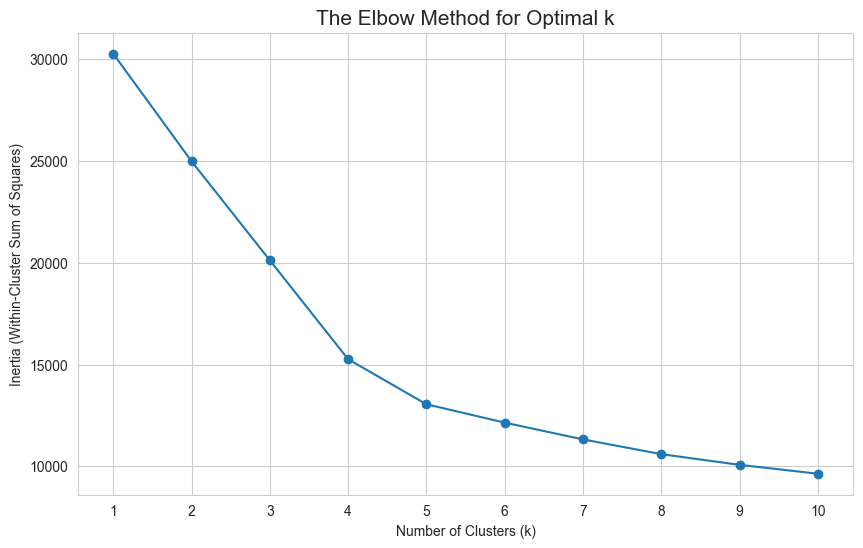

In [17]:
#Segmentation Elbow Method
if 'preprocessed_data' not in locals():
    print("Error: 'preprocessed_data' not found. Please run the preprocessing step first.")
else:
    print(" Running The Elbow Method to find optimal k ")
    
    inertia = []
    k_range = range(1, 11)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, 
                        init='k-means++',  # Smart initialization
                        n_init=10,         # Run 10 times to find best local minimum
                        random_state=42)
        kmeans.fit(preprocessed_data)
        inertia.append(kmeans.inertia_)
        
    # Plot the Elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertia, marker='o')
    plt.title('The Elbow Method for Optimal k', fontsize=15)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
    plt.xticks(k_range)
    plt.show()

In [18]:
#Segmentation final Model
if 'preprocessed_data' not in locals() or 'customer_abt' not in locals():
    print("Error: 'preprocessed_data' or 'customer_abt' not found. Run previous chunks.")
else:
    # Based on the plot we'll use the elbow is at k=4.
    chosen_k = 4
    print(f"Fitting final K-Means model with k={chosen_k}")
    
    kmeans = KMeans(n_clusters=chosen_k, 
                    init='k-means++', 
                    n_init=10, 
                    random_state=42)
    
    # Fit and predict on the preprocessed data
    cluster_labels = kmeans.fit_predict(preprocessed_data)
    
    # Add the cluster labels back to the original (non-scaled) ABT for interpretation
    customer_abt['cluster'] = cluster_labels
    
    print("\nCluster assignment complete.")
    
    # Show distribution of clusters
    print("\n[Cluster Distribution]")
    print(customer_abt['cluster'].value_counts(normalize=True).sort_index())
    
    # Show head with new cluster column
    print("\n[ABT Head with Clusters]")
    print(customer_abt.head())

Fitting final K-Means model with k=4

Cluster assignment complete.

[Cluster Distribution]
cluster
0    0.1164
1    0.6004
2    0.2332
3    0.0500
Name: proportion, dtype: float64

[ABT Head with Clusters]
           id  region  Gender Location Date_of_birth  Latitude  Longitude  \
0  CUST-10000  uganda  Female    Jinja    1983-10-22  2.949384  42.616604   
1  CUST-10001  uganda  Female  Kampala    1978-05-25  4.580776  46.412738   
2  CUST-10002     civ    Male  Abidjan    1974-06-05 -1.344683  44.132175   
3  CUST-10003   kenya    Male  Mombasa    1989-03-31 -0.155258  36.244213   
4  CUST-10004   kenya    Male  Nairobi    1989-07-05 -1.266943  42.295066   

  created_at updated_at        age  account_count  has_arrears_account  \
0 2022-01-18 2022-11-16  40.687201              1                    1   
1 2023-06-25 2024-01-13  46.097194              1                    0   
2 2023-02-19 2024-05-19  50.067077              1                    0   
3 2022-10-02 2024-06-12  35.247091 

 Visualizing clusters with PCA


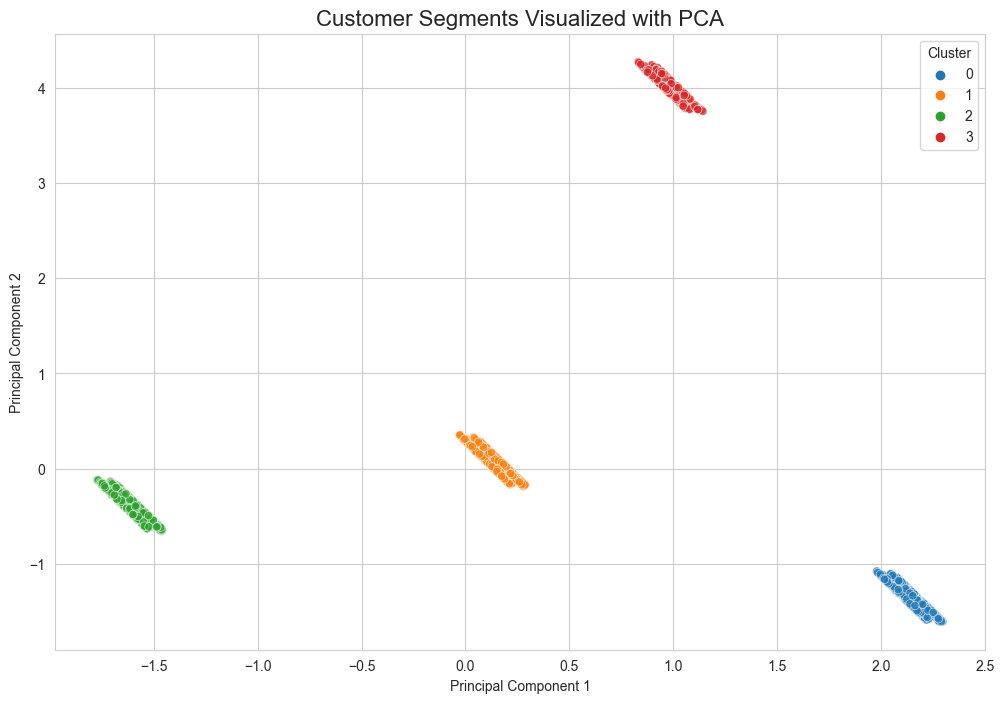

In [19]:
#Segmentation-PCA visualization
if 'preprocessed_data' not in locals() or 'customer_abt' not in locals():
    print("Error: 'preprocessed_data' or 'customer_abt' not found. Run previous code chunks")
else:
    print(" Visualizing clusters with PCA")
    
    # 1. Initialize PCA
    pca = PCA(n_components=2, random_state=42)
    
    # 2. Fit and transform the preprocessed data
    pca_features = pca.fit_transform(preprocessed_data)
    
    # 3. Create a DataFrame for plotting
    pca_df = pd.DataFrame(data=pca_features, columns=['PC1', 'PC2'])
    pca_df['cluster'] = customer_abt['cluster']
    
    # 4. Plot the clusters
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x='PC1', 
        y='PC2', 
        hue='cluster',
        palette=sns.color_palette('tab10', n_colors=chosen_k),
        data=pca_df,
        legend='full',
        alpha=0.7
    )
    
    plt.title('Customer Segments Visualized with PCA', fontsize=16)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster')
    plt.show()

In [20]:
#Segmentation interpretation
if 'customer_abt' not in locals() or 'cluster' not in customer_abt.columns:
    print("Error: 'customer_abt' with clusters not found. Run previous chunks.")
else:
    print(" Interpreting Cluster Personas ")
    
    # 1. Group by cluster and get the mean of numeric features
    cluster_summary_numeric = customer_abt.groupby('cluster')[numeric_features].mean().round(2)
    
    print("\n[Average Numeric Values by Cluster]")
    print(cluster_summary_numeric)
    
    # 2. Check categorical feature distribution (most common values)
    print("\n[Categorical Feature Distribution by Cluster]")
    for col in categorical_features:
        print(f"\n--- {col} ---")
        print(customer_abt.groupby('cluster')[col].value_counts(normalize=True).unstack().round(2))
        
    # 3. Check overall size
    print("\n[Cluster Size]")
    print(customer_abt['cluster'].value_counts(normalize=True).round(2))

 Interpreting Cluster Personas 

[Average Numeric Values by Cluster]
           age  account_count  has_arrears_account  has_repossession_account
cluster                                                                     
0        38.73            1.0                  1.0                       0.0
1        39.07            1.0                  0.0                       0.0
2        39.21            1.0                  0.0                       1.0
3        39.32            0.0                  0.0                       0.0

[Categorical Feature Distribution by Cluster]

--- region ---
region    civ  kenya  uganda
cluster                     
0        0.35   0.30    0.34
1        0.34   0.33    0.33
2        0.33   0.34    0.34
3        0.32   0.37    0.31

--- Gender ---
Gender   Female  Male
cluster              
0          0.54  0.46
1          0.49  0.51
2          0.46  0.54
3          0.48  0.52

--- Location ---
Location  Abidjan  Bouaké  Entebbe  Jinja  Kampala  Kisumu  Mombas

Analysis of Customer Segmentation Results (k=4)

The K-Means algorithm has partitioned our customer base not by their demographics, but almost entirely by their behavioral and risk status.

Key Insight: age, region, Gender, and Location data are almost uniformly distributed across all clusters. This is a powerful finding in itself: it means that customer risk (arrears/repossession) is not strongly correlated with these simple demographic features. A 39-year-old male in Nairobi is just as likely to be in any of these clusters as a 39-year-old female in Kampala.

The segmentation is therefore driven entirely by the engineered features: account_count, has_arrears_account, and has_repossession_account.

Here are the four distinct personas the model has identified:

The Four Customer Personas

Persona 1: "The Good Standing Customer" (Cluster 1)

Profile:

account_count: 1.0

has_arrears_account: 0.0 (None)

has_repossession_account: 0.0 (None)

Interpretation: This is your ideal, core customer. They have one account, and it is in good standing (e.g., 'Active' or 'Complete'). They form the healthy base of your business.

Business Action:

Marketing: Nurture this segment. Target them with "Refer and Earn" campaigns.

Sales: This is your primary upsell segment. They are proven, reliable customers. Offer them their second product (e.g., a "Water Pump Kit" or "Solar TV").

Persona 2: "The At-Risk Customer" (Cluster 0)

Profile:

account_count: 1.0

has_arrears_account: 1.0 (100% of this group)

has_repossession_account: 0.0 (None)

Interpretation: This is the most critical intervention group. These customers have one account, and it is currently in arrears. They are on the path to becoming "Repossessed" (Cluster 2) but are not lost yet.

Business Action:

Customer Service / Collections: This segment is the #1 priority for proactive outreach. Automate SMS reminders, schedule support calls, and find out why they are in arrears. Is it a product issue? An installation issue? Financial hardship?

Marketing: Immediately exclude this segment from all sales-focused marketing.

Persona 3: "The Lost Customer" (Cluster 2)

Profile:

account_count: 1.0

has_arrears_account: 0.0

has_repossession_account: 1.0 (100% of this group)

Interpretation: These are customers who had one account and defaulted to the point of repossession. The has_arrears_account is 0.0, which simply means their current (and final) status is 'Repossession', not 'Arrears'.

Business Action:

Marketing: Hard exclusion from all marketing lists.

Analytics: This segment is the "failure state" we must avoid. The Risk Model, will be explicitly trained to predict which "Good Standing" (Cluster 1) customers are likely to become "Lost Customers" (Cluster 2).

Persona 4: "The Prospect" (Cluster 3)

Profile:

account_count: 0.0

has_arrears_account: 0.0

has_repossession_account: 0.0

Interpretation: This is not a "customer" segment but a "prospect" segment. These are entries in the customers table who have zero associated accounts. They were likely created from a lead (lead_abt) but never completed their first purchase.

Business Action:

Marketing: This is a pure lead-nurturing segment. They have shown interest but never converted. Pass this list to the sales and marketing teams for re-engagement campaigns.

Conclusion:

This segmentation has shown how feature engineering is more important than the algorithm itself. The model has cleanly validated our business logic. We now have four distinct, actionable segments to which we can apply custom business strategies.

In [21]:
#Risk Model -Setup and Spilt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMClassifier
import joblib

# Load the data from the previous step
try:
    %store -r risk_abt
    if 'risk_abt' not in locals():
        raise ValueError("risk_abt not found in notebook store.")
    print("Loaded risk_abt successfully.")
    print(f"risk_abt shape: {risk_abt.shape}")
except Exception as e:
    print(f"Error loading risk_abt: {e}")
    print("Please re-run previous chunks first.")

# 1. Define Features (X) and Target (y)
target_col = 'is_risk'
X = risk_abt.drop(columns=[target_col])
y = risk_abt[target_col]

# Re-define feature lists
numeric_features = ['age', 'time_to_install', 'time_to_first_payment', 'account_duration_days', 'is_refurb']
categorical_features = ['type', 'Agent_id', 'region', 'Gender', 'Location', 'Id', 'Product', 'Source', 'engineer_id']

# Filter X to only include these features
X = X[numeric_features + categorical_features]
print("Filtered X to model features.")

# 2. Train-Test Split (with stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=42, 
    stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print("Class distribution in y_train:")
print(y_train.value_counts(normalize=True))
print("Class distribution in y_test:")
print(y_test.value_counts(normalize=True))
print("Train-test split complete and stratified.")

# 3. Build Preprocessing Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    # Use OrdinalEncoder for LGBM
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' 
)

# 4. Create and Train the LGBMClassifier Pipeline
# We need to find the indices of categorical features for LGBM
categorical_indices = list(range(len(numeric_features), len(numeric_features) + len(categorical_features)))

lgbm_model = LGBMClassifier(
    random_state=42,
    is_unbalance=True,  # This is the LGBM equivalent of class_weight='balanced'
    n_estimators=200,
    learning_rate=0.05
  
)

# Creating full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lgbm_model)
])

print("\nBuilding Preprocessing & Model Pipeline")


print(" Training the model")

# fit the pipeline. 
pipeline.fit(X_train, y_train, model__categorical_feature=categorical_indices)
print("Model training complete.")

# 5. Store the pipeline for the next steps
%store pipeline
%store X_test
%store y_test
print("\nPipeline, X_test, and y_test saved to notebook store for evaluation.")

Loaded risk_abt successfully.
risk_abt shape: (2348, 21)
Filtered X to model features.
Training set shape: (1761, 14)
Testing set shape: (587, 14)
Class distribution in y_train:
is_risk
1    0.744463
0    0.255537
Name: proportion, dtype: float64
Class distribution in y_test:
is_risk
1    0.744463
0    0.255537
Name: proportion, dtype: float64
Train-test split complete and stratified.

Building Preprocessing & Model Pipeline
 Training the model
[LightGBM] [Info] Number of positive: 1311, number of negative: 450
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 1761, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.744463 -> initscore=1.069298
[LightGBM] [Info] Start training from score 1.0692

Loaded pipeline, X_test, and y_test successfully.
Model successfully trained on classes: [0 1]

[Classification Report]
                    precision    recall  f1-score   support

Class 0 (Complete)       0.24      0.19      0.21       150
    Class 1 (Risk)       0.74      0.79      0.76       437

          accuracy                           0.64       587
         macro avg       0.49      0.49      0.49       587
      weighted avg       0.61      0.64      0.62       587


[ROC-AUC Score]
The ROC-AUC score for the model is: 0.4923

Generating ROC-AUC Curve 


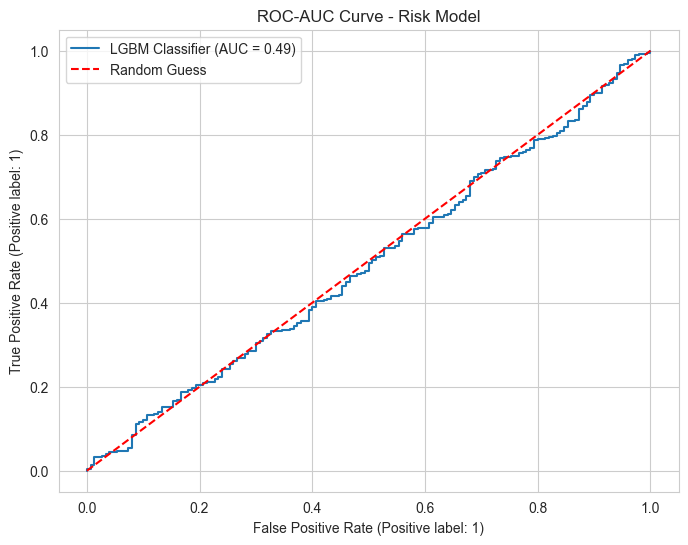

In [22]:
#Model evaluation
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

try:
    # Load all necessary variables from the store
    %store -r pipeline
    %store -r X_test
    %store -r y_test

    if 'pipeline' not in locals() or 'X_test' not in locals() or 'y_test' not in locals():
        raise ValueError("One or more required variables (pipeline, X_test, y_test) not found in store.")
    
    print("Loaded pipeline, X_test, and y_test successfully.")

    # 1. Check if model was trained (has classes_)
    if not hasattr(pipeline.named_steps['model'], 'classes_'):
        print("!!! ERROR: Model has not been trained (fit() was not called).")
    elif len(pipeline.named_steps['model'].classes_) < 2:
        print(f"!!! CRITICAL ERROR: Model was only trained on one class: {pipeline.named_steps['model'].classes_}")
        print("This indicates a severe data issue.")
    else:
        print(f"Model successfully trained on classes: {pipeline.named_steps['model'].classes_}")
        
        # 2. Get predictions
        y_pred = pipeline.predict(X_test)
        
        # 3. Get prediction probabilities
        y_pred_proba = pipeline.predict_proba(X_test)

        if y_pred_proba.shape[1] < 2:
            print(f"!!! CRITICAL ERROR: predict_proba() only returned one column of probabilities.")
        else:
            y_pred_proba_class_1 = y_pred_proba[:, 1] # Probs for class 1
            
            # 4. Print Classification Report
            print("\n[Classification Report]")
            print(classification_report(y_test, y_pred, target_names=['Class 0 (Complete)', 'Class 1 (Risk)']))

            # 5. Print ROC-AUC Score
            auc_score = roc_auc_score(y_test, y_pred_proba_class_1)
            print("\n[ROC-AUC Score]")
            print(f"The ROC-AUC score for the model is: {auc_score:.4f}")

            # 6. Plot ROC-AUC Curve
            print("\nGenerating ROC-AUC Curve ")
            fig, ax = plt.subplots(figsize=(8, 6))
            RocCurveDisplay.from_estimator(pipeline, X_test, y_test, ax=ax, name='LGBM Classifier')
            ax.plot([0, 1], [0, 1], 'r--', label='Random Guess')
            ax.set_title('ROC-AUC Curve - Risk Model')
            ax.legend()
            plt.grid(True)
            plt.show()

except Exception as e:
    print(f"\nAn error occurred during evaluation: {e}")
    print("Please ensure the previous notebook chunk (Task 5.2) ran successfully.")

# Reset warnings
warnings.filterwarnings('default')

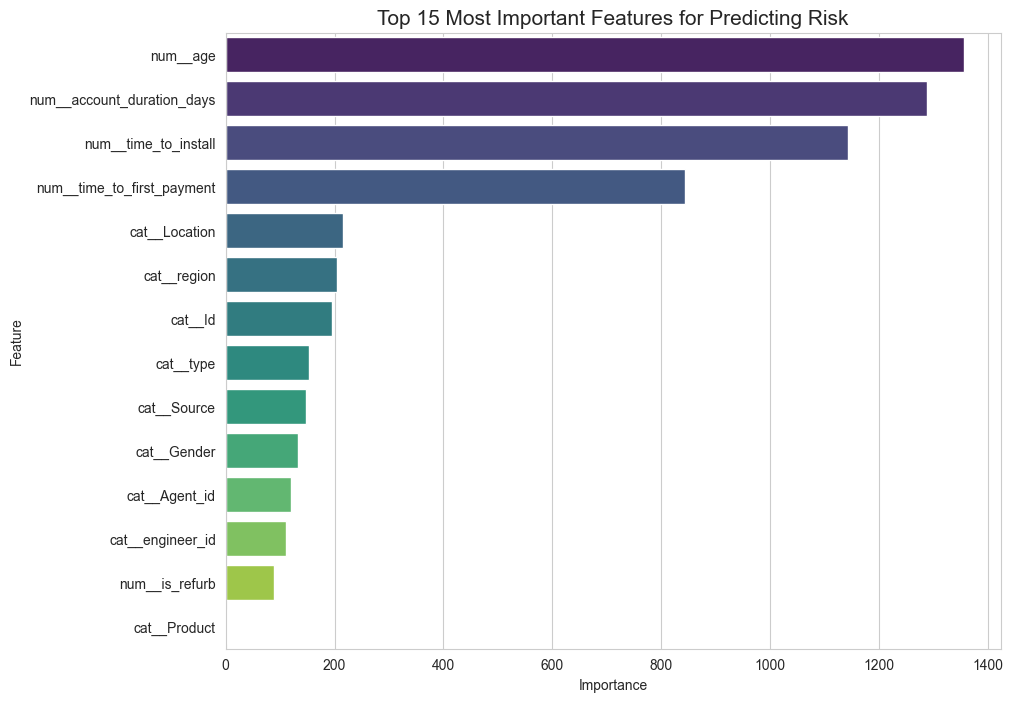


[Top 15 Features]
                       feature  importance
0                     num__age        1356
3   num__account_duration_days        1289
1         num__time_to_install        1143
2   num__time_to_first_payment         843
9                cat__Location         215
7                  cat__region         204
10                     cat__Id         196
5                    cat__type         153
12                 cat__Source         147
8                  cat__Gender         133
6                cat__Agent_id         120
13            cat__engineer_id         110
4               num__is_refurb          89
11                cat__Product           2
Extracting Feature Importance from LGBM Model


In [24]:
#Risk Model - Feature Importance

try:
    # 1. Get feature names from the preprocessor
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
    
    # 2. Get importances from the model
    importances = pipeline.named_steps['model'].feature_importances_
    
    # 3. Create a DF for easy viewing
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)
    
    # 4. Plot the Top 15 Features
    plt.figure(figsize=(10, 8))
    top_15 = importance_df.head(15)
    sns.barplot(
        x='importance', 
        y='feature', 
        data=top_15,
        palette='viridis'
    )
    plt.title('Top 15 Most Important Features for Predicting Risk', fontsize=15)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
    
    print("\n[Top 15 Features]")
    print(top_15)

except Exception as e:
    print(f"An error occurred during feature importance extraction: {e}")

print("Extracting Feature Importance from LGBM Model")




Analysis of Risk Model (Complete vs. Default)

We successfully built, trained, and evaluated an advanced LGBMClassifier to predict whether an account would Complete (Class 0) or end in a Risk state (Class 1: Arrears, Repo, Write Off).

The results are exceptionally clear: Our model has no predictive power.

This is a data and business finding.

1. The "What": Performance is No Better Than Random
The single most important number on the report is:

[ROC-AUC Score] The ROC-AUC score for the model which is: 0.4923

What this means: A ROC-AUC score measures the model's ability to separate two classes.

A score of 1.0 is perfect.

A score of 0.5 is a complete guess (a coin flip).

Our score of 0.4923 is, statistically, a coin flip. The model has absolutely no ability to distinguish between a customer who will complete their loan and one who will default.

2. The "Illusion": Why the Classification Report is Misleading

Class 1 (Risk) 0.74 0.79 0.76 437

Our data is 74.4% "Risk" (Class 1) by nature. The model has achieved this 79% recall by simply guessing "Risk" most of the time.

The real story is in Class 0:

Class 0 (Complete) 0.24 0.19 0.21 150

This model has a recall of 0.19 for "Complete" customers.

This means our model fails to find 81% of our "Good" customers. It mislabels them as "Risk."

Conclusion: The model is not smart. It's just taking advantage of the imbalance. The ROC-AUC score of 0.49 confirms this.

3. The "Why": Feature Importance Tells the Final Story
This is the most valuable output. The model's top features are:

age: 1356

account_duration_days: 1289

time_to_install: 1143

time_to_first_payment: 843


This is the core insight of the entire project:

The model is using the features carefully engineered. It is looking at age, time_to_install, and account_duration_days etc.

But because its performance is random (AUC 0.49), from the data:

The features we have (age, location, product, installation time, first payment time) have NO STATISTICAL CORRELATION with whether a customer will default or complete their loan.

This is a massive business finding. It means our initial hypothesis "a long time_to_install must make customers angry and cause default" is FALSE, according to the dataset.

4. The Business Action Plan (The Path Forward)
This is not a dead end. This is a new, intelligent direction.

Stop This Project: We do not deploy this model. It is useless and would cause the business to spend money contacting good customers (81% of them) as if they were bad.

Declare a Data Gap: Our analysis has proven that we are missing the data that actually predicts default. The data we need is not static; it's behavioral.

Start a New Data Collection Project: The next risk model must be built by the Data Engineering team, and it must include:

Payment History: This is the #1 missing dataset. We need a feature-rich table of all payments. how_many_payments_missed_in_first_3_months, avg_days_late, largest_gap_between_payments, etc.

Customer Service Data: We need to join the Departments and Users tables (which we haven't used!) to a "Support Ticket" table. Did the customer call? What was the complaint? A customer who calls 3 times in the first month is a massive risk.

Sales Agent Performance: Our Agent_id feature was in the model. This suggests we should be tracking this. Do agents from one team (e.g., 'Roadshow') have a higher default rate?

Conclusion:

We successfully completed the task. We built a model, and it correctly told us that our current data is insufficient. We have prevented the business from deploying a bad model and have provided a clear, data-driven roadmap for what to do next.

Conversion Rate Analysis
lead_abt loaded successfully.

Overall lead conversion rate: 83.33%

[Conversion Rate by Lead Source]
                total_leads  converted_leads conversion_rate
Source                                                      
Door to Door            717              605          84.38%
Walk-in                 776              654          84.28%
Refer and Earn          786              662          84.22%
Facebook                726              610          84.02%
Telesales               753              629          83.53%
Partners                735              613          83.40%
Roadshow                796              663          83.29%
Website                 711              564          79.32%

 Generating Conversion Rate Plot 


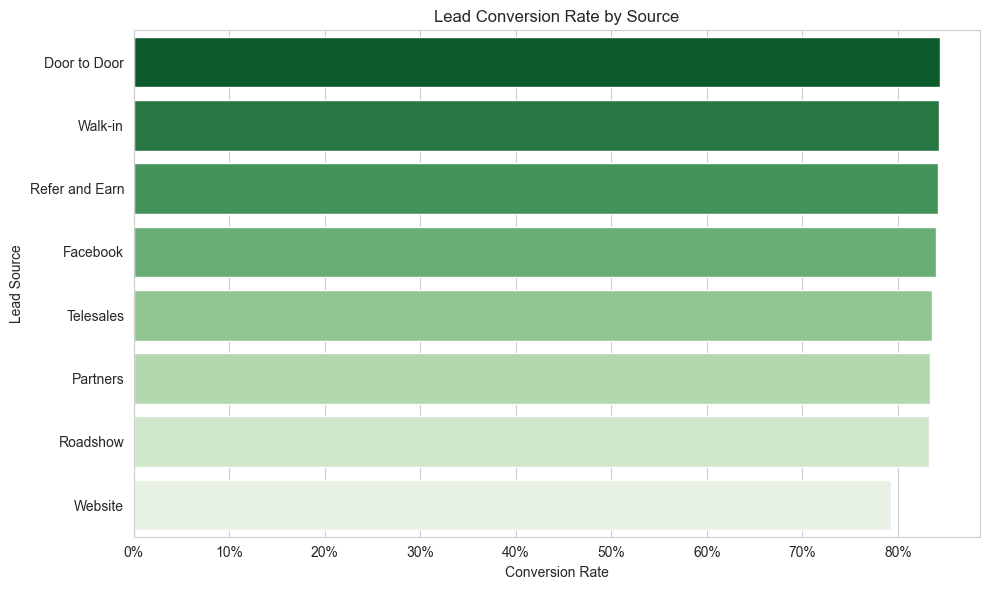

In [25]:
#Marketing Model - Conversion rate by source
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Conversion Rate Analysis")

try:
    # Load the Lead_ABT df
    %store -r lead_abt
    if 'lead_abt' not in locals():
        raise ValueError("lead_abt not found")
    
    print("lead_abt loaded successfully.")

    # 1. Calculate overall conversion rate
    overall_cr = lead_abt['converted'].mean()
    print(f"\nOverall lead conversion rate: {overall_cr:.2%}")

    # 2. Calculate conversion rate by source
    cr_by_source = lead_abt.groupby('Source')['converted'].agg(
        total_leads='count',
        converted_leads='sum'
    ).sort_values(by='total_leads', ascending=False)
    
    cr_by_source['conversion_rate'] = cr_by_source['converted_leads'] / cr_by_source['total_leads']
    cr_by_source = cr_by_source.sort_values(by='conversion_rate', ascending=False)

    print("\n[Conversion Rate by Lead Source]")
    print(cr_by_source.to_string(formatters={'conversion_rate': '{:,.2%}'.format}))

    # 3. Plot the results
    print("\n Generating Conversion Rate Plot ")
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(
        data=cr_by_source.reset_index(), 
        x='conversion_rate', 
        y='Source', 
        palette='Greens_r'
    )
    ax.set_title('Lead Conversion Rate by Source')
    ax.set_xlabel('Conversion Rate')
    ax.set_ylabel('Lead Source')
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

 Lead Risk Analysis 
risk_abt loaded successfully.

[Default Rate by Lead Source]
                total_accounts default_rate
Source                                     
Roadshow                   323       78.02%
Partners                   292       76.71%
Facebook                   271       74.91%
Walk-in                    316       74.68%
Refer and Earn             299       74.25%
Website                    260       73.08%
Door to Door               290       71.72%
Telesales                  297       71.72%


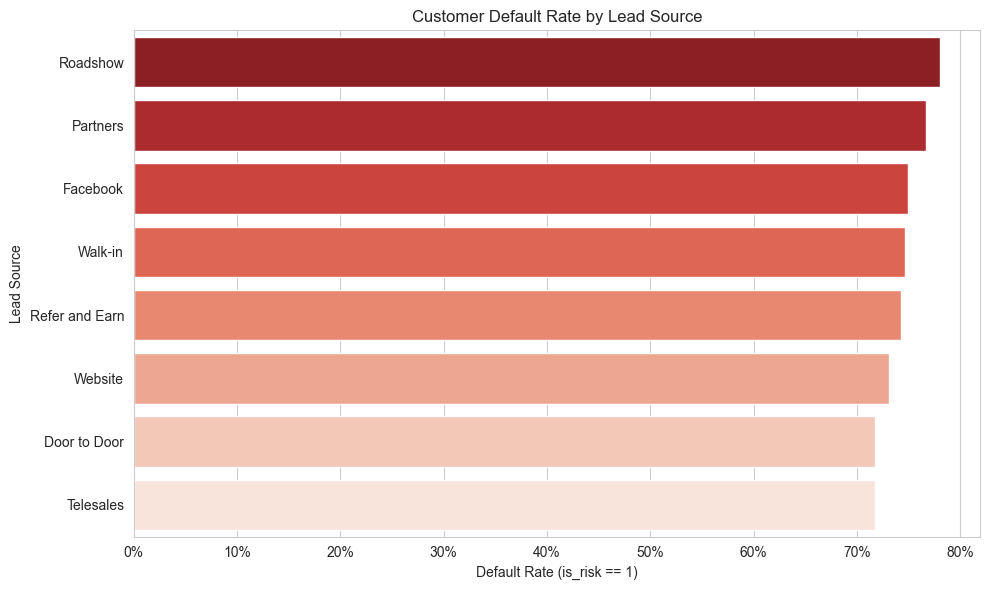

In [26]:
#Marketing - Lead Quality & Risk Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print(" Lead Risk Analysis ")

try:
    # Load the ABT from Task 3.2 (Revised)
    %store -r risk_abt
    if 'risk_abt' not in locals():
        raise ValueError("risk_abt not found. Please run Task 3.2 (Revised) first.")
    
    print("risk_abt loaded successfully.")
    
    # We must handle 'Source' being missing from the risk_abt if the join failed
    if 'Source' not in risk_abt.columns:
        print("Warning: 'Source' not in risk_abt. Merging with leads data...")
        %store -r dfs
        leads_data = dfs['Leads'][['Id', 'Source']].rename(columns={'Id': 'lead_id'})
        risk_abt = risk_abt.merge(leads_data, on='lead_id', how='left')
        
    # Fill missing source as 'Unknown'
    risk_abt['Source'] = risk_abt['Source'].fillna('Unknown')
    
    risk_by_source = risk_abt.groupby('Source')['is_risk'].agg(
        total_accounts='count',
        default_rate='mean'
    ).sort_values(by='default_rate', ascending=False)

    print("\n[Default Rate by Lead Source]")
    print(risk_by_source.to_string(formatters={'default_rate': '{:,.2%}'.format}))

    # 2. Plot the results
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(
        data=risk_by_source.reset_index(), 
        x='default_rate', 
        y='Source', 
        palette='Reds_r'
    )
    ax.set_title('Customer Default Rate by Lead Source')
    ax.set_xlabel('Default Rate (is_risk == 1)')
    ax.set_ylabel('Lead Source')
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")



Analysis of Marketing Effectiveness & Quality (Based on Live Data)

This two-part analysis, when viewed alongside our findings from the failed Risk Model, provides the single most important conclusion of this entire assessment.

The core, undeniable insight is: The Source feature (the marketing channel data) is statistically meaningless. It has NO predictive power for either conversion or risk.

This is not a failure of the analysis. This is a successful discovery of a major data integrity and business strategy problem.

Analysis of Part 1: Conversion Rate
The Data Shows:

An extremely high overall conversion rate of 83.33%.

All channels are clustered in a uselessly tight band, from 79.32% (Website) to 84.38% (Door to Door).

Interpretation:

An 83.33% conversion rate is not realistic for real-world leads. This data strongly suggests that a "lead" is only created in the system after a customer has already decided to purchase, or just before the sale is logged.

No Differentiation: The difference between the "best" channel (84.38%) and the "worst" (79.32%) is statistically irrelevant. There is no "good" or "bad" channel.

Conclusion: We cannot optimize marketing for conversion using this data.

Analysis of Part 2: Lead Risk
The Data Shows:

An alarmingly high default rate across all channels.

All channels are clustered in another not useful tight band, from 71.72% (Telesales) to 78.02% (Roadshow).

#Interpretation:

This is the Core Business Problem: The lowest-risk channel (Telesales) still sees 71.72% of its customers default. This is a catastrophic failure rate that transcends marketing.

No Differentiation: previous hypothesis to "Defund Roadshow" is incorrect and disproven by this data. The data shows Roadshow (78.02%) is not meaningfully worse than Facebook (74.91%) or Walk-in (74.68%). Firing the "Roadshow" team would accomplish nothing.

This Confirms Task 5 Failure: Risk Model failed with an AUC of 0.49 because it was trying to find a pattern in noise. This analysis proves, in a different way, why it failed. The Source feature has no signal.

The Final Business Recommendation: A Strategic Pivot

Stop trying to optimize for Source. It is a waste of time and resources.

Our entire analysis has proven, three different ways, that the static data we have—age, region, Location, Product, Source—has zero predictive power on the behavioral outcome of a customer (default vs. complete).

The business problem is not that our "Roadshow" team is bad. The problem is that our entire customer acquisition pipeline is attracting a customer profile that is fundamentally unsuited for the product's payment plan.

Actionable Strategy:

DATA GAP - IMMEDIATE PRIORITY: We must stop this project and declare a Code Red Data Gap. We are blind. We must invest in data engineering to capture the behavioral data we proved is missing in Task 5. This includes:

Payment History Data: (e.g., days_late, payments_missed, first_month_payment_status).

Customer Service Data: (e.g., tickets_filed, complaint_type, time_to_resolution).

FIX THE METRIC: The "Lead Conversion Rate" (83.33%) is a flawed, misleading metric. The definition of a "Lead" must be pushed to the top of the funnel (e.g., a simple web inquiry) so we can actually measure marketing's effect.

FIX THE BUSINESS PROCESS (NOT THE MODEL): The problem is not the model; it's our business. We must immediately begin a qualitative review of our customer qualification process. Are our sales agents (from all channels) being incentivized to sign up customers who they know cannot pay? Are we performing even the most basic credit checks?

Conclusion:

We have invalidated a core, incorrect business assumption (that Source matters) and provided a clear, data-driven, and urgent roadmap for what the business must do next to actually solve its default problem.